<a href="https://colab.research.google.com/github/RajSinha77/DL-Reg-implementation-/blob/main/DLReg_vs_L2_on_resnet%26densenet_on_oxford_iiit_pet_Dataset_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3680
    })
    test: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3669
    })
})
Epoch 1/30, Train Acc: 0.0794836956521739, Val Acc: 0.11684782608695651, Test Acc: 0.11801580812210412
Epoch 2/30, Train Acc: 0.3257472826086956, Val Acc: 0.639945652173913, Test Acc: 0.6582174979558463
Epoch 3/30, Train Acc: 0.8138586956521738, Val Acc: 0.8478260869565217, Test Acc: 0.8588171163804852
Epoch 4/30, Train Acc: 0.9110054347826086, Val Acc: 0.8709239130434783, Test Acc: 0.8765331152902699
Epoch 5/30, Train Acc: 0.9378396739130435, Val Acc: 0.8777173913043478, Test Acc: 0.8697192695557373
Epoch 6/30, Train Acc: 0.9656929347826086, Val Acc: 0.9130434782608695, Test Acc: 0.9002452984464432
Epoch 7/30, Train Acc: 0.975883152173913, Val Acc: 0.8994565217391304, Test Acc: 0.8953393295175798
Epoch 8/30, Train Acc: 0.9850543478260869

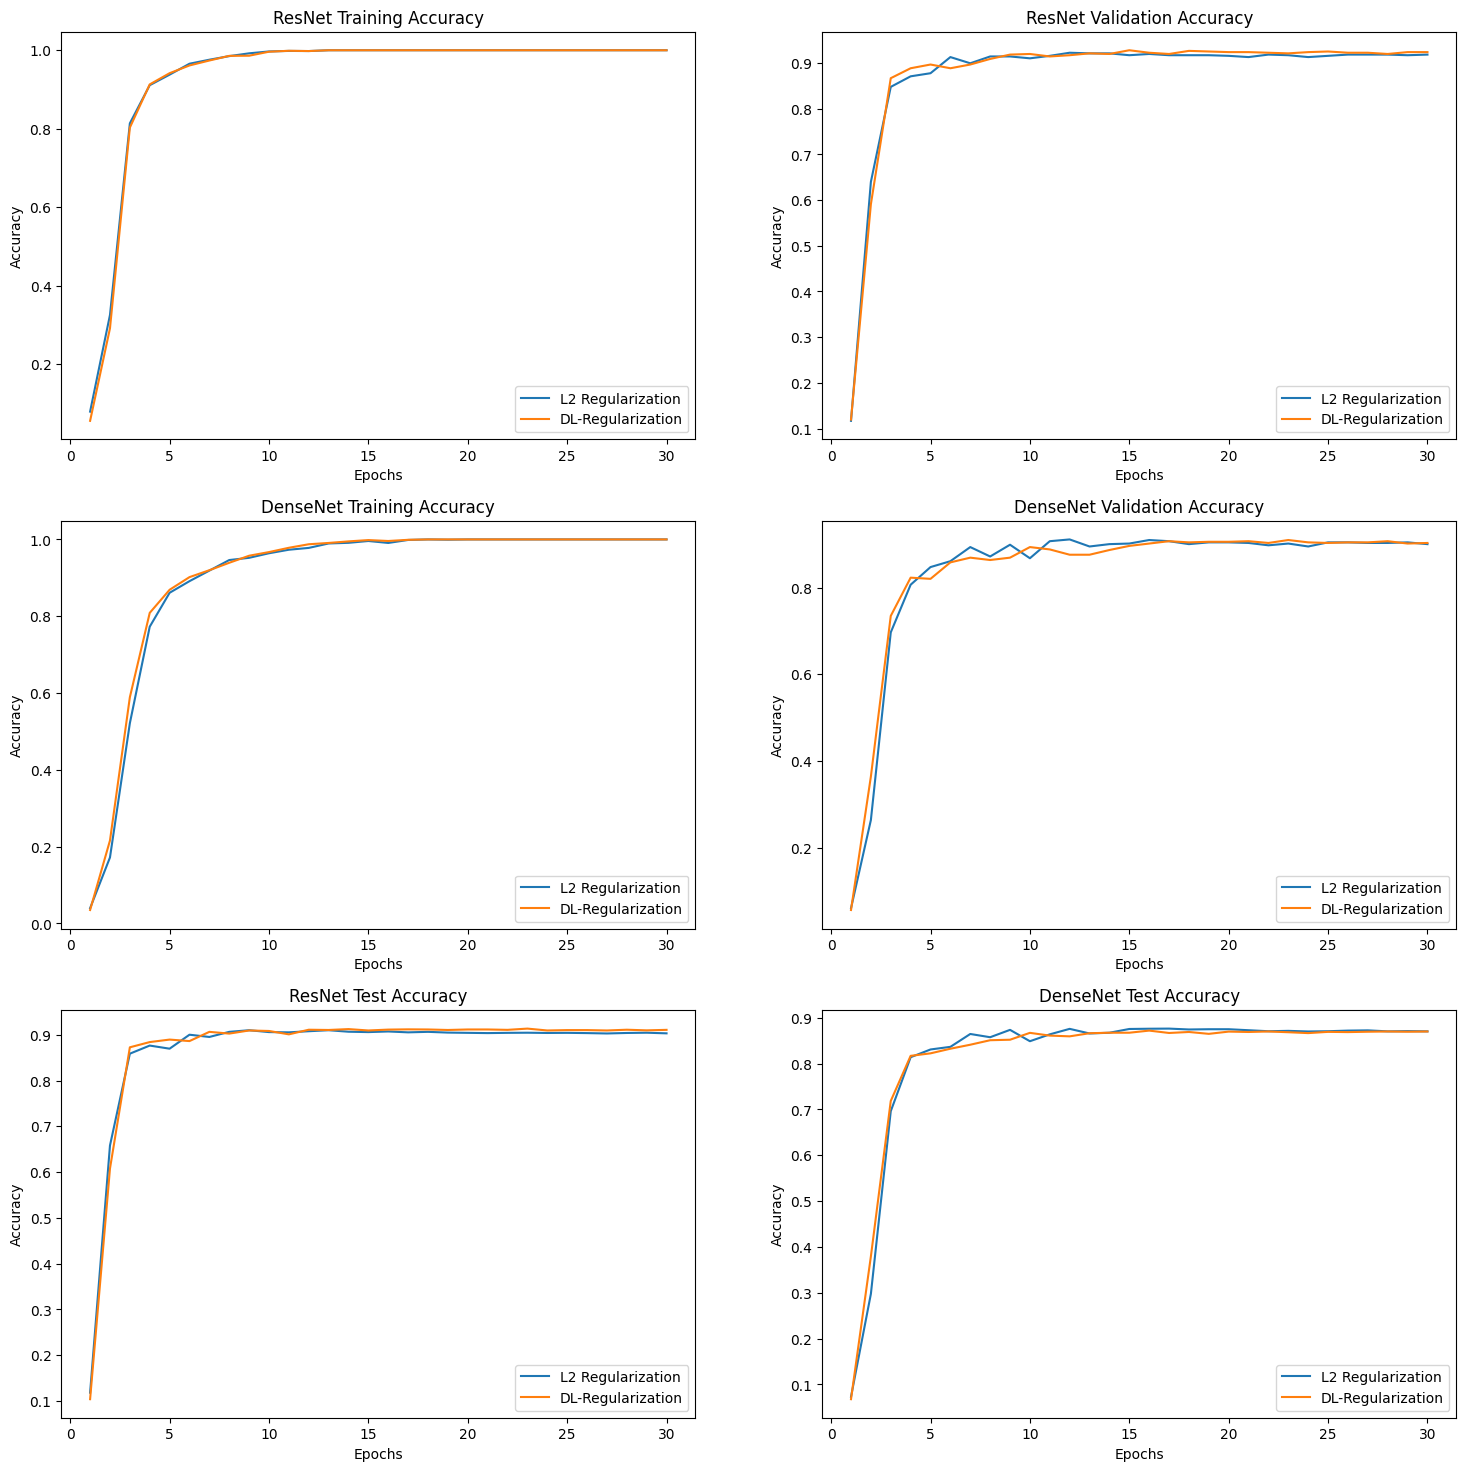

In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Define constants
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

# Load the Oxford-IIIT Pet dataset from Hugging Face
dataset = load_dataset('timm/oxford-iiit-pet')

# Print the dataset structure to check available splits
print(dataset)

# Identify the correct splits
train_split = 'train'
test_split = 'test'

# Custom dataset class to handle Hugging Face dataset
class OxfordIIITPetDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations for the Oxford-IIIT Pet dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode != "RGB" else x),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare the dataset and dataloaders
train_val_dataset = OxfordIIITPetDataset(dataset[train_split], transform=transform)
test_dataset = OxfordIIITPetDataset(dataset[test_split], transform=transform)

# Split the train dataset into train and validation sets
train_size = int((1 - VALIDATION_SPLIT) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the models with updated weights parameter
resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Modify the final layers to fit Oxford-IIIT Pet classes (37 classes)
num_ftrs_resnet = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs_resnet, 37)

num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)

# Define DL-Regularization
class DLRegularization(nn.Module):
    def __init__(self, model, lambda_reg=0.0000001):
        super(DLRegularization, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg

    def forward(self, x):
        output = self.model(x)
        return output

    def dl_reg_loss(self, x, output):
        batch_size = x.size(0)
        Z = nn.Linear(x.view(batch_size, -1).size(1), output.size(1), bias=False).to(x.device)
        reg_loss = torch.norm(Z(x.view(batch_size, -1)) - output) ** 2
        return self.lambda_reg * reg_loss

# Training function
def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS, dl_regularizer=None):
    model.train()
    train_acc = []
    val_acc = []
    test_acc = []

    for epoch in range(num_epochs):
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if dl_regularizer:
                reg_loss = dl_regularizer.dl_reg_loss(inputs, outputs)
                loss += reg_loss

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(train_dataset)
        train_acc.append(epoch_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_acc = val_corrects.double() / len(val_dataset)
        val_acc.append(epoch_val_acc.item())

        # Test
        test_corrects = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)

        epoch_test_acc = test_corrects.double() / len(test_dataset)
        test_acc.append(epoch_test_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {epoch_acc.item()}, Val Acc: {epoch_val_acc.item()}, Test Acc: {epoch_test_acc.item()}')

    return train_acc, val_acc, test_acc

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experiment with L2 regularization on ResNet
resnet152 = resnet152.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet152.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
train_acc_l2_resnet, val_acc_l2_resnet, test_acc_l2_resnet = train_model(resnet152, criterion, optimizer)

# Experiment with DL-Regularization on ResNet
resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
num_ftrs_resnet = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs_resnet, 37)
resnet152 = resnet152.to(device)
optimizer = optim.SGD(resnet152.parameters(), lr=LEARNING_RATE)
dl_regularizer = DLRegularization(resnet152, lambda_reg=0.0000001)
train_acc_dl_resnet, val_acc_dl_resnet, test_acc_dl_resnet = train_model(resnet152, criterion, optimizer, dl_regularizer=dl_regularizer)

# Experiment with L2 regularization on DenseNet
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)
densenet = densenet.to(device)
optimizer = optim.SGD(densenet.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
train_acc_l2_densenet, val_acc_l2_densenet, test_acc_l2_densenet = train_model(densenet, criterion, optimizer)

# Experiment with DL-Regularization on DenseNet
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)
densenet = densenet.to(device)
optimizer = optim.SGD(densenet.parameters(), lr=LEARNING_RATE)
dl_regularizer = DLRegularization(densenet, lambda_reg=0.0000001)
train_acc_dl_densenet, val_acc_dl_densenet, test_acc_dl_densenet = train_model(densenet, criterion, optimizer, dl_regularizer=dl_regularizer)

# Plotting the results
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(18, 18))

plt.subplot(3, 2, 1)
plt.plot(epochs, train_acc_l2_resnet, label='L2 Regularization')
plt.plot(epochs, train_acc_dl_resnet, label='DL-Regularization')
plt.title('ResNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epochs, val_acc_l2_resnet, label='L2 Regularization')
plt.plot(epochs, val_acc_dl_resnet, label='DL-Regularization')
plt.title('ResNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(epochs, train_acc_l2_densenet, label='L2 Regularization')
plt.plot(epochs, train_acc_dl_densenet, label='DL-Regularization')
plt.title('DenseNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epochs, val_acc_l2_densenet, label='L2 Regularization')
plt.plot(epochs, val_acc_dl_densenet, label='DL-Regularization')
plt.title('DenseNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(epochs, test_acc_l2_resnet, label='L2 Regularization')
plt.plot(epochs, test_acc_dl_resnet, label='DL-Regularization')
plt.title('ResNet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(epochs, test_acc_l2_densenet, label='L2 Regularization')
plt.plot(epochs, test_acc_dl_densenet, label='DL-Regularization')
plt.title('DenseNet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [5]:
def calculate_accuracy(accuracy_list):
    final_accuracy = accuracy_list[-1] * 100
    return final_accuracy

# Calculate test accuracies
test_acc_l2_resnet_pct = calculate_accuracy(test_acc_l2_resnet)
test_acc_dl_resnet_pct = calculate_accuracy(test_acc_dl_resnet)
test_acc_l2_densenet_pct = calculate_accuracy(test_acc_l2_densenet)
test_acc_dl_densenet_pct = calculate_accuracy(test_acc_dl_densenet)

# Print test accuracies
print(f'Test Accuracy of ResNet with L2 Regularization: {test_acc_l2_resnet_pct:.2f}%')
print(f'Test Accuracy of ResNet with DL-Regularization: {test_acc_dl_resnet_pct:.2f}%')
print(f'Test Accuracy of DenseNet with L2 Regularization: {test_acc_l2_densenet_pct:.2f}%')
print(f'Test Accuracy of DenseNet with DL-Regularization: {test_acc_dl_densenet_pct:.2f}%')

Test Accuracy of ResNet with L2 Regularization: 90.32%
Test Accuracy of ResNet with DL-Regularization: 91.09%
Test Accuracy of DenseNet with L2 Regularization: 87.03%
Test Accuracy of DenseNet with DL-Regularization: 87.00%
